<a href="https://colab.research.google.com/github/fmahboub/Replicating-Burgstahler-and-Dichev-1997/blob/master/Accruals%20Anomaly%20Persistance%20(2010-2018).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install wrds

     |████████████████████████████████| 2.9MB 4.0MB/s 


In [0]:
# Reference: Burgstahler and Dichev (1997)

import pandas as pd
import wrds
import matplotlib.pyplot as plt
conn = wrds.Connection()

import numpy as np
from scipy.stats.mstats import winsorize
from scipy import stats

Enter your WRDS username [root]:faran2
Enter your password:··········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [0]:
# 1. Sample selection
funda = conn.raw_sql("""
                      select gvkey, fyear, ni, csho, prcc_f, sich
	                  from compa.funda where
	                   (consol='C' and indfmt='INDL' and datafmt='STD' and popsrc='D') and
                       fyear<2019 and
                       fyear>2007
                      """) 
company = conn.raw_sql("""
                      select gvkey, sic
	                  from compa.company
                     """) 

funda1=pd.merge(funda,company,on=['gvkey'])
funda1['sic1']=np.where(funda1['sich']>0,funda1['sich'],funda1['sic'])
funda1=funda1.drop(['sich','sic'],axis=1)
funda1['sic1']=funda1['sic1'].astype(int)

# industry restriction
indexNames =funda1[ (funda1['sic1'] >= 4400) & (funda1['sic1'] <= 5000) ].index
funda1.drop(indexNames , inplace=True)
indexNames =funda1[ (funda1['sic1'] >= 6000) & (funda1['sic1'] <= 6500) ].index
funda1.drop(indexNames , inplace=True)


# 2. Variable construction
funda1.describe()
funda1['mv']=funda1['csho']*funda1['prcc_f']
# Note: mkvalt is not complete. Units for Ni: million, csho: million, 

# generate lag variables
funda1_lag1= funda1[['gvkey','fyear','ni','mv']].copy() 
funda1_lag1['fyear']=funda1_lag1['fyear']+1
funda1_lag1=funda1_lag1.rename(columns={'mv':'mv_lag1','ni':'earn_lag1'})

funda1=pd.merge(funda1,funda1_lag1, how='left', on=['gvkey','fyear'])

funda1_lag1= funda1[['gvkey','fyear','mv_lag1']].copy() 
funda1_lag1['fyear']=funda1_lag1['fyear']+1
funda1_lag1=funda1_lag1.rename(columns={'mv_lag1':'mv_lag2'})

funda1=pd.merge(funda1,funda1_lag1, how='left', on=['gvkey','fyear'])

# generate test variables
funda1=funda1.rename(columns={'ni':'earn'})

funda1['earnchg'] = funda1['earn'] - funda1['earn_lag1']

# scale earn with mv_lag1 and earnchg with mv_lag2
funda1=funda1.dropna()
funda1

,gvkey,fyear,earn,csho,prcc_f,sic1,mv,earn_lag1,mv_lag1,mv_lag2,earnchg
2,001004,2010.0,69.826,39.781,26.3900,5080,1049.820590,44.628,777.834800,571.594800,25.198
3,001004,2011.0,67.723,40.273,12.0500,5080,485.289650,69.826,1049.820590,777.834800,-2.103
4,001004,2012.0,55.000,39.382,20.0600,5080,790.002920,67.723,485.289650,1049.820590,-12.723
5,001004,2013.0,72.900,39.560,24.3000,5080,961.308000,55.000,790.002920,485.289650,17.900
6,001004,2014.0,10.200,35.423,29.5400,5080,1046.395420,72.900,961.308000,790.002920,-62.700
...,...,...,...,...,...,...,...,...,...,...,...
100993,317427,2017.0,164.100,166.792,16.9100,2030,2820.452720,38.409,1756.946730,2184.780000,125.691
100994,317427,2018.0,196.006,174.229,16.7200,2030,2913.108880,164.100,2820.452720,1756.946730,31.906
101003,318815,2017.0,-21.733,30.542,0.8375,2836,25.578925,-24.874,67.206000,81.159900,3.141
101004,318815,2018.0,-19.156,30.592,0.1550,2836,4.741760,-21.733,25.578925,67.206000,2.577


In [0]:
# winsorize before doing scales.
varlist=['earn','mv_lag1','mv_lag2','earn_lag1']
for var in varlist:
    funda1[var] = funda1[var].replace(np.Inf, np.nan)
    funda1[var]=np.where(funda1[var].isnull(), np.nan, winsorize(funda1[var], limits=(0.01,0.01)))

# Do scales
funda1['earn_s']=funda1['earn']/funda1['mv_lag1']
funda1['earnchg_s'] = funda1['earnchg']/funda1['mv_lag2']

In [0]:
funda3=funda1[['gvkey','fyear','earn_s']]
# winsorize again for the scaled variables. 
funda2=funda3.dropna()
funda2.describe()

varlist=['earn_s']
for var in varlist:
    funda2[var] = funda2[var].replace(np.Inf, np.nan)
    funda2[var]=np.where(funda2[var].isnull(), np.nan, winsorize(funda2[var], limits=(0.01,0.01)))

In [0]:
# Table 1 (Panel B)
destable=funda2.describe().transpose()  # pooled sample
desearn_s=funda2.groupby('fyear')['earn_s'].describe() # Table 1 Panel B
desearn_s = desearn_s.round(decimals=2)
desearn_s = desearn_s.drop(desearn_s.columns[[3, 7]], axis=1)
print("-------------- Table 1 Panel B -------------")
print(desearn_s)

-------------- Table 1 Panel B -------------
         count  mean   std   25%   50%   75%
fyear                                       
2010.0  5204.0 -0.09  0.49 -0.10  0.03  0.08
2011.0  5037.0 -0.07  0.42 -0.09  0.03  0.07
2012.0  5040.0 -0.10  0.47 -0.13  0.02  0.07
2013.0  5083.0 -0.13  0.51 -0.14  0.01  0.07
2014.0  5393.0 -0.16  0.57 -0.15  0.00  0.05
2015.0  5351.0 -0.19  0.60 -0.18 -0.01  0.05
2016.0  5288.0 -0.21  0.64 -0.19 -0.01  0.05
2017.0  5157.0 -0.16  0.57 -0.16  0.00  0.05
2018.0  4669.0 -0.12  0.48 -0.13  0.01  0.05


In [0]:
funda4=funda1[['gvkey','fyear','earnchg_s']]
# winsorize again for the scaled variables. 
funda5=funda4.dropna()
funda5.describe()

varlist=['earnchg_s']
for var in varlist:
    funda5[var] = funda5[var].replace(np.Inf, np.nan)
    funda5[var]=np.where(funda5[var].isnull(), np.nan, winsorize(funda5[var], limits=(0.03,0.03)))

In [0]:
# Table 1 (Panel A)
destable=funda5.describe().transpose()  # pooled sample
desearn_s=funda5.groupby('fyear')['earnchg_s'].describe() # Table 1 Panel A
desearn_s = desearn_s.round(decimals=2)
desearn_s = desearn_s.drop(desearn_s.columns[[3, 7]], axis=1)
print("-------------- Table 1 Panel A -------------")
print(desearn_s)

-------------- Table 1 Panel A -------------
         count  mean   std   25%   50%   75%
fyear                                       
2010.0  5204.0  0.08  0.37 -0.03  0.02  0.15
2011.0  5037.0  0.00  0.29 -0.05  0.01  0.06
2012.0  5040.0 -0.00  0.24 -0.05  0.00  0.04
2013.0  5083.0  0.01  0.27 -0.05  0.00  0.05
2014.0  5393.0  0.00  0.29 -0.05  0.00  0.05
2015.0  5351.0 -0.01  0.29 -0.06 -0.00  0.03
2016.0  5288.0  0.03  0.30 -0.04  0.00  0.06
2017.0  5157.0  0.02  0.32 -0.04  0.01  0.06
2018.0  4669.0  0.00  0.28 -0.05  0.00  0.05


<function matplotlib.pyplot.show>

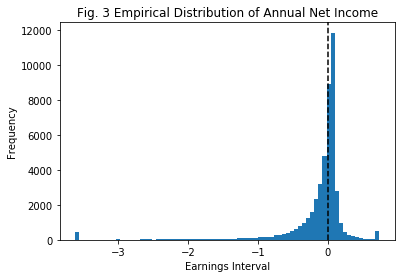

In [0]:
# Figure 3

plt.hist(funda2['earn_s'], bins=75)
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Earnings Interval')
plt.ylabel('Frequency')
plt.title('Fig. 3 Empirical Distribution of Annual Net Income')
plt.show

<function matplotlib.pyplot.show>

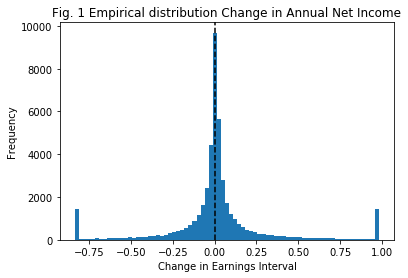

In [0]:
# Figure 1

plt.hist(funda5['earnchg_s'], bins=75)
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Change in Earnings Interval')
plt.ylabel('Frequency')
plt.title('Fig. 1 Empirical distribution Change in Annual Net Income')
plt.show